## Word2Vec (Skip-Gram version) with TensorFlow
___
#### Description:

Word2Vec is a predictive model for learning word embeddings. Check out the references below understand how it works.
___
#### References:

Understanding Word2Vec:

http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/


Implementing Word2Vec:

https://www.tensorflow.org/tutorials/word2vec
https://github.com/tensorflow/tensorflow/blob/r1.7/tensorflow/examples/tutorials/word2vec/word2vec_basic.py


Other:

https://stackoverflow.com/questions/41475180/understanding-tf-nn-nce-loss-in-tensorflow/42392407





## Imports and constants

In [1]:
# Import dependencies
import collections
import os
import random
import zipfile
import numpy as np
import tensorflow as tf
from six.moves import urllib
from tensorflow.contrib.tensorboard.plugins import projector # for tensorboard projector

C:\Users\Marvin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Source URL
SOURCE_URL = 'http://mattmahoney.net/dc/'

# Log directory
LOGDIR = r'C:\Users\Marvin\Desktop\MachineLearning\Code\Word_Embeddings\log'

# Hyperparameters
vocab_size = 50000 # size of vocabulary
skip_window =  1 # number of words to consider to the left or right
num_skips = 2 # number of context words per target word input
batch_size = 128 # batch size
num_sampled = 20 # number of negative/noise words to sample
embedding_size = 100 # embedding size
num_iters = 100001

# Initialize data index to 0
data_index = 0

## Download the data

In [3]:
# Function to download the data
def maybe_download(filename, data_dir):
    # Create directory to store data if it does not already exist
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    # Download the data if it hasn't already been downloaded
    filepath = os.path.join(data_dir, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)  
        print('Download complete')        
    return filepath

In [4]:
# Function to read the data from a zip file as separate words
def read_data(filepath):
    with zipfile.ZipFile(filepath) as f:
        data = f.read(f.namelist()[0]).decode('ascii').split()        
    return data

In [5]:
# Download the data
filepath = maybe_download(filename='text8.zip', data_dir='dataset')

In [6]:
# Read the data
data = read_data(filepath)

In [7]:
print('Number of words in corpus:', len(data))
print('\nFirst 10 words in corpus:', data[:10])

Number of words in corpus: 17005207

First 10 words in corpus: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


## Convert words in data to integers

In [8]:
def preprocess_data(data, vocab_size):
    """
    Returns:
    new_data           - The original data but with words substituted with their word IDs
    word_count         - A list of tuples where a tuple represents a word and its count
    dictionary         - A dictionary that maps words to their IDs
    reverse_dictionary - A dictionary that maps word IDs to words
    """
    # A list of tuples containing the most common words and their count (excluding 'UNK' word)
    temp = collections.Counter(data).most_common(vocab_size-1)
    # Vocabulary
    vocab = [word for word, _ in temp]
    # Create dictionary that maps a word to its word ID
    dictionary = {word: code+1 for code, word in enumerate(vocab)}
    dictionary['UNK'] = 0
    # Create dictionary that maps a word ID to its word
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    # Convert every word in data to its word ID
    new_data = [dictionary.get(word, 0) for word in data]
    # A list of tuples containing the most common words and their count (including 'UNK' word)
    word_count = [('UNK', new_data.count(0))]
    word_count.extend(temp)
    return new_data, word_count, dictionary, reverse_dictionary

In [9]:
# Convert the data to integers
data, word_count, dictionary, reverse_dictionary = preprocess_data(data=data, vocab_size=vocab_size)

In [10]:
print('First 10 words in corpus as integers:')
print(data[:10])
print('\n10 most common words and their count:')
print(word_count[:10])

First 10 words in corpus as integers:
[5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]

10 most common words and their count:
[('UNK', 418391), ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]


In [11]:
# Dictionary mapping word IDs to their frequency
# Used in sample_data() function
word_freq = {dictionary[word]: count/len(data) for word, count in word_count}

In [12]:
# Function that removes some words in data that occur too frequently
# Done in word2vec paper to improve performance
def sample_data(data, sample=1e-3):
    new_data = []
    for word_id in data:
        freq = word_freq[word_id]
        keep_prob = np.clip((np.sqrt(freq/sample)+1) * sample / freq, 0, 1)
        keep = np.random.choice([0, 1],1,p=[1-keep_prob,keep_prob])
        if keep == 1:
            new_data.append(word_id)
    return new_data

In [13]:
# Remove some word IDs in data that occur too frequently
data = sample_data(data)
# takes a while

In [14]:
print('Number of words in corpus:', len(data)) # a decrease from original
print('\nFirst 10 words in corpus as integers:') # slightly different from before
print(data[:10])

Number of words in corpus: 12502866

First 10 words in corpus as integers:
[5234, 3081, 12, 6, 195, 3134, 46, 59, 156, 128]


## Function to generate a batch of data

In [15]:
# Helper function to get context words
def get_context(num_skips=num_skips, skip_window=skip_window):
    left_window = data[data_index:data_index + skip_window]
    right_window = data[data_index + skip_window + 1: data_index + 2*skip_window + 1]
    full_window = left_window + right_window
    context = random.sample(full_window, num_skips)
    return context

In [16]:
# Helper function to select next training example
def next_example(num_skips=num_skips, skip_window=skip_window):
    global data_index
    # Loop to start of data if at end
    if (data_index + 2*skip_window + 1) > len(data):
        data_index = 0
    # Select the next target word
    target_id = data[data_index + skip_window]    
    context_id = get_context()
    data_index += 1
    return [target_id] * num_skips, context_id

In [17]:
# Function to generate next batch
def generate_batch(batch_size=batch_size, num_skips=num_skips, skip_window=skip_window):
    global data_index  
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    inputs = []
    labels = []
    for b in range(batch_size // num_skips):
        target, context = next_example()  
        # Add target/context to batch/labels list
        inputs = inputs + target
        labels = labels + context    
    inputs = np.array(inputs)
    labels = np.array(labels).reshape(-1,1)    
    return inputs, labels

## Construct graph

In [18]:
# Reset graph
tf.reset_default_graph()

In [19]:
# Placeholders
X = tf.placeholder(tf.int32, shape=[batch_size]) # vector containing input word IDs
y = tf.placeholder(tf.int32, shape=[batch_size, 1]) # vector containing output word IDs

# Embeddings variable + lookup
with tf.name_scope('embeddings'):
    embeddings = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, X) # essentially the hidden layer

# NCE weight variable
with tf.name_scope('weights'):
    nce_weights = tf.Variable(tf.truncated_normal(
        [vocab_size, embedding_size], stddev=1.0 / np.sqrt(embedding_size)))

# NCE bias variable
with tf.name_scope('biases'):
    nce_biases = tf.Variable(tf.zeros([vocab_size]))

# Loss
with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=y,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocab_size))
    
    tf.summary.scalar('loss', loss)

# Optimizer
with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

# Merge all summaries
merged = tf.summary.merge_all()

## Creating Saver and FileWriter

In [20]:
# Create a saver
saver = tf.train.Saver()

# Create FileWriter to write in summaries, model graph and projector config
writer = tf.summary.FileWriter(LOGDIR)

## TensorBoard preparations

In [21]:
# Configure the Projector for visualizing embeddings
config = projector.ProjectorConfig()
embedding_config = config.embeddings.add()
embedding_config.tensor_name = embeddings.name
embedding_config.metadata_path = os.path.join(LOGDIR, 'metadata.tsv')

# Write in the Projector configurations
projector.visualize_embeddings(writer, config)

# Write in the metadata
with open(LOGDIR + '/metadata.tsv', 'w') as f:
    for i in range(vocab_size):
        f.write(reverse_dictionary[i] + '\n')

## Create a session

In [22]:
with tf.Session() as sess:
    # Write in the graph
    writer.add_graph(sess.graph)
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Training
    average_loss = 0
    
    for i in range(num_iters):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        
        _, summary, loss_val = sess.run([optimizer, merged, loss], feed_dict={X: batch_inputs, y: batch_labels})
        
        average_loss += loss_val
        writer.add_summary(summary, i)
        
        # Print average loss over the last 2000 batches
        if i % 2000 == 0:
            if i > 0:
                average_loss /= 2000
            print('Average loss at step', i, ':', average_loss)
            average_loss = 0

    # Final embeddings
    final_embeddings = embeddings.eval()
    
    # Save the session
    saver.save(sess, os.path.join(LOGDIR, 'model.ckpt'))

    # Close FileWriter
    writer.close()

Average loss at step 0 : 104.3299789428711
Average loss at step 2000 : 62.299338232040405
Average loss at step 4000 : 40.991168101787565
Average loss at step 6000 : 32.3626319425106
Average loss at step 8000 : 27.18908659720421
Average loss at step 10000 : 22.817161728024484
Average loss at step 12000 : 19.590431699991225
Average loss at step 14000 : 17.668353781938553
Average loss at step 16000 : 15.690170443773269
Average loss at step 18000 : 14.454102758169174
Average loss at step 20000 : 13.161759730815888
Average loss at step 22000 : 11.640759320616722
Average loss at step 24000 : 10.722652519702912
Average loss at step 26000 : 10.199351063966752
Average loss at step 28000 : 9.464729863762855
Average loss at step 30000 : 8.853762914180756
Average loss at step 32000 : 8.61271292436123
Average loss at step 34000 : 7.7614832675457
Average loss at step 36000 : 7.551175325393677
Average loss at step 38000 : 7.2577500731945035
Average loss at step 40000 : 7.3400950756073
Average loss at

## Visualizing embeddings using t-SNE

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# Number of embeddings to fit t-SNE on
num_embeddings = 500

# Reduce dimension of embeddings using t-SNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
new_embeddings = tsne.fit_transform(final_embeddings[:num_embeddings, :])

# Corresponding words for the reduced embeddings
labels = [reverse_dictionary[word_id] for word_id in range(num_embeddings)]


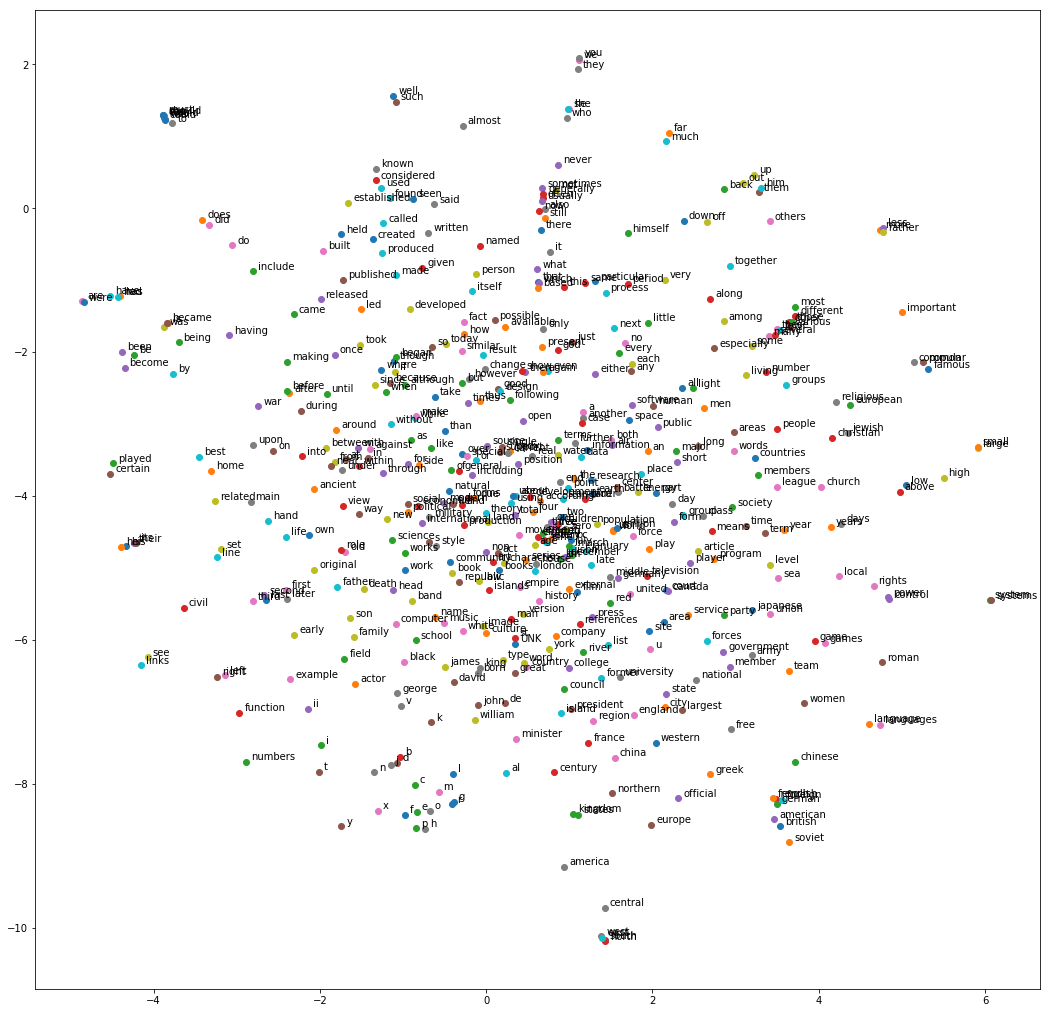

In [24]:
# Plot the reduced embeddings
plt.figure(figsize=(18,18))
for i, label in enumerate(labels):
        x, y = new_embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points')

# Can also visualize t-SNE graph in TensorBoard